# Logistic Regression #1: Crazy Sauce Prediction

## Objective
Predict whether a customer who orders **Crazy Schnitzel** will also order **Crazy Sauce**.

This is a binary classification problem:
- **Input (X)**: Features of the receipt (other products, cart size, time, etc.)
- **Output (y)**: 1 if Crazy Sauce was purchased, 0 otherwise
- **Filter**: Only receipts containing Crazy Schnitzel

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from data_loader import load_raw_data, SAUCES, split_by_receipt
from preprocessing import prepare_lr_data, normalize_features, get_feature_names
from models.logistic_regression import LogisticRegression
from models.evaluation import (
    accuracy, precision, recall, f1_score, 
    confusion_matrix, print_classification_report
)

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

## 1. Load and Prepare Data

In [2]:
# Load raw data
DATA_PATH = Path('../data/raw/ap_dataset.csv')
df = load_raw_data(DATA_PATH)

print(f"Total rows: {len(df)}")
print(f"Total receipts: {df['id_bon'].nunique()}")

Total rows: 28039
Total receipts: 7869


In [3]:
# Check Crazy Schnitzel and Crazy Sauce counts
cs_receipts = df[df['retail_product_name'] == 'Crazy Schnitzel']['id_bon'].nunique()
sauce_receipts = df[df['retail_product_name'] == 'Crazy Sauce']['id_bon'].nunique()

print(f"Receipts with Crazy Schnitzel: {cs_receipts}")
print(f"Receipts with Crazy Sauce: {sauce_receipts}")

Receipts with Crazy Schnitzel: 1783
Receipts with Crazy Sauce: 1594


In [4]:
# Prepare data for LR
# Filter: only receipts with Crazy Schnitzel
# Target: did they also buy Crazy Sauce?
# Features: other products (excluding all sauces to prevent data leakage)

X, y, features_df = prepare_lr_data(
    df, 
    target_sauce='Crazy Sauce',
    filter_product='Crazy Schnitzel',
    exclude_all_sauces=True
)

print(f"\nPrepared dataset:")
print(f"  Total samples (receipts): {len(y)}")
print(f"  Features: {X.shape[1]}")
print(f"  Positive samples (bought Crazy Sauce): {y.sum()} ({100*y.mean():.1f}%)")
print(f"  Negative samples: {len(y) - y.sum()} ({100*(1-y.mean()):.1f}%)")


Prepared dataset:
  Total samples (receipts): 1783
  Features: 56
  Positive samples (bought Crazy Sauce): 948 (53.2%)
  Negative samples: 835 (46.8%)


In [5]:
# Feature names for interpretability
feature_names = get_feature_names(features_df)
print(f"\nFeature names ({len(feature_names)}):")
for i, name in enumerate(feature_names[:10]):
    print(f"  {i+1}. {name}")
print("  ...")


Feature names (56):
  1. has_Packaging
  2. has_Crazy Schnitzel
  3. has_Aqua Carpatica Plata 0.5L
  4. has_Mac & cheease
  5. has_Baked potatoes
  6. has_Breaded Chicken Schnitzel
  7. has_Pepsi Twist Zero Can 0.33L
  8. has_Pepsi Cola 0.25L Doze
  9. has_Mac & Cheese with Crispy Bacon
  10. has_Extra bacon
  ...


## 2. Train/Test Split

In [6]:
# Split at receipt level (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(y_train)} samples")
print(f"  Positive: {y_train.sum()} ({100*y_train.mean():.1f}%)")
print(f"\nTest set: {len(y_test)} samples")
print(f"  Positive: {y_test.sum()} ({100*y_test.mean():.1f}%)")

Training set: 1426 samples
  Positive: 758 (53.2%)

Test set: 357 samples
  Positive: 190 (53.2%)


In [7]:
# Normalize features (z-score)
X_train_norm, train_mean, train_std = normalize_features(X_train)
X_test_norm, _, _ = normalize_features(X_test, mean=train_mean, std=train_std)

print("Features normalized using z-score normalization")
print(f"Training mean range: [{train_mean.min():.3f}, {train_mean.max():.3f}]")
print(f"Training std range: [{train_std.min():.3f}, {train_std.max():.3f}]")

Features normalized using z-score normalization
Training mean range: [0.001, 86.712]
Training std range: [0.026, 37.940]


## 3. Train Logistic Regression Model

In [8]:
# Create and train model
model = LogisticRegression(
    learning_rate=0.1,
    n_iterations=1000,
    regularization=0.01,  # L2 regularization
    verbose=True
)

model.fit(X_train_norm, y_train)

Iteration 100/1000, Loss: 0.5674
Iteration 200/1000, Loss: 0.5619
Iteration 300/1000, Loss: 0.5602
Iteration 400/1000, Loss: 0.5595
Iteration 500/1000, Loss: 0.5590
Iteration 600/1000, Loss: 0.5586
Iteration 700/1000, Loss: 0.5582
Iteration 800/1000, Loss: 0.5580
Iteration 900/1000, Loss: 0.5577
Iteration 1000/1000, Loss: 0.5575


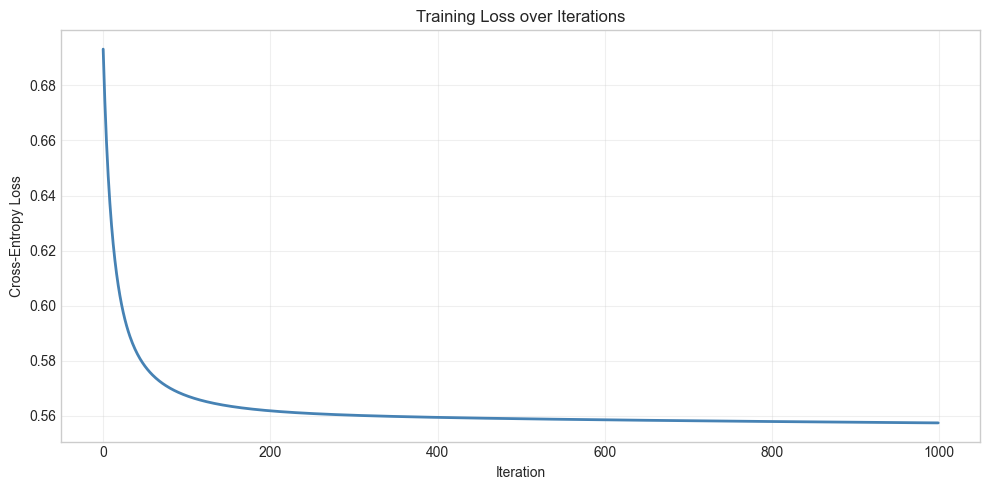

Initial loss: 0.6931
Final loss: 0.5575


In [9]:
# Plot training loss
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(model.loss_history, color='steelblue', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Cross-Entropy Loss')
ax.set_title('Training Loss over Iterations')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/lr1_training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Initial loss: {model.loss_history[0]:.4f}")
print(f"Final loss: {model.loss_history[-1]:.4f}")

## 4. Model Evaluation

In [10]:
# Predictions on test set
y_pred_proba = model.predict_proba(X_test_norm)
y_pred = model.predict(X_test_norm, threshold=0.5)

# Classification report
print("TEST SET RESULTS")
print_classification_report(y_test, y_pred)

TEST SET RESULTS
CLASSIFICATION REPORT

Total Samples: 357
  - Positive: 190 (53.2%)
  - Negative: 167 (46.8%)

Confusion Matrix:
              Predicted
              Neg    Pos
  Actual Neg     77     90
  Actual Pos     18    172

Metrics:
  Accuracy:    0.6975
  Precision:   0.6565
  Recall:      0.9053
  F1 Score:    0.7611
  Specificity: 0.4611


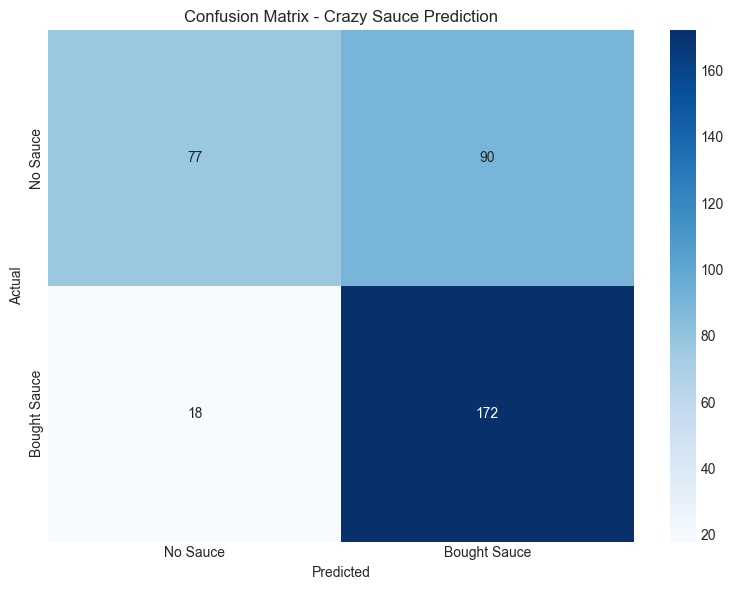

In [11]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['No Sauce', 'Bought Sauce'],
            yticklabels=['No Sauce', 'Bought Sauce'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Crazy Sauce Prediction')
plt.tight_layout()
plt.savefig('../results/lr1_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

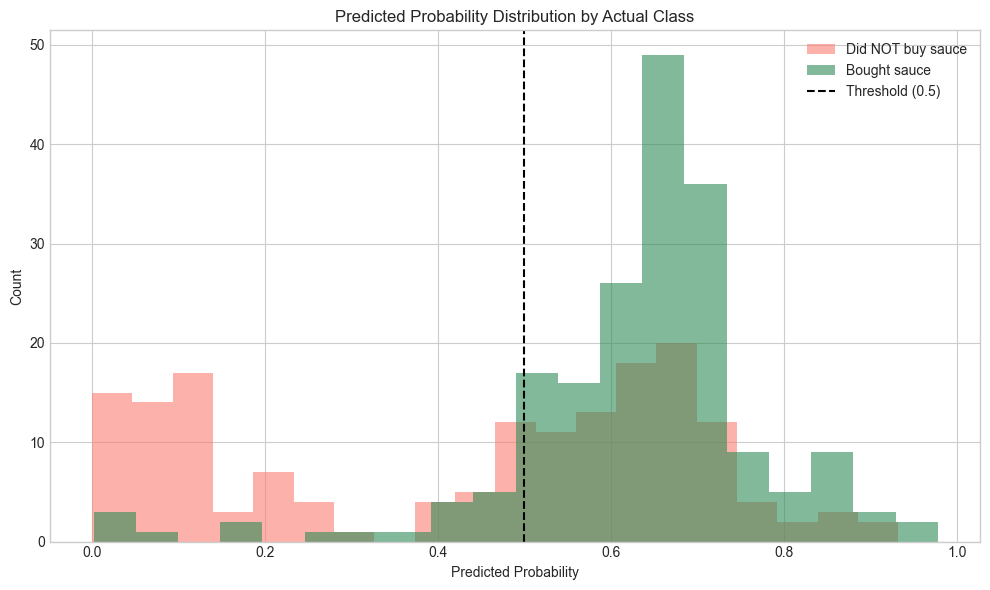

In [12]:
# Probability distribution
fig, ax = plt.subplots(figsize=(10, 6))

# Separate by actual class
proba_neg = y_pred_proba[y_test == 0]
proba_pos = y_pred_proba[y_test == 1]

ax.hist(proba_neg, bins=20, alpha=0.6, label='Did NOT buy sauce', color='salmon')
ax.hist(proba_pos, bins=20, alpha=0.6, label='Bought sauce', color='seagreen')
ax.axvline(0.5, color='black', linestyle='--', label='Threshold (0.5)')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Count')
ax.set_title('Predicted Probability Distribution by Actual Class')
ax.legend()
plt.tight_layout()
plt.savefig('../results/lr1_probability_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Feature Importance

In [13]:
# Get feature importance
importance = model.get_feature_importance(feature_names)

# Top 15 most important features
top_features = list(importance.items())[:15]

print("Top 15 Most Important Features:")
print("-" * 50)
for name, data in top_features:
    direction = "POSITIVE" if data['weight'] > 0 else "NEGATIVE"
    print(f"{name:40s} {data['weight']:+.4f} ({direction})")

Top 15 Most Important Features:
--------------------------------------------------
distinct_products                        +0.7846 (POSITIVE)
has_Breaded Chicken Schnitzel            -0.4179 (NEGATIVE)
has_Crazy Fries with Parmesan            -0.3659 (NEGATIVE)
has_Mac & cheease                        +0.3411 (POSITIVE)
has_Prigat Still Orange 0.25L            -0.3309 (NEGATIVE)
has_Pepsi Cola 0.25L Doze                +0.2795 (POSITIVE)
has_Breaded Pork Schnitzel               -0.2659 (NEGATIVE)
has_Mac & Cheese with Crispy Bacon       -0.2593 (NEGATIVE)
has_Red Fit Schnitzel                    -0.2329 (NEGATIVE)
has_Prigat Still Peach Apricot 0.25L     -0.2292 (NEGATIVE)
cart_size                                +0.2237 (POSITIVE)
has_Viennese Schnitzel                   -0.1853 (NEGATIVE)
has_Crazy Fries with Cheddar Sauce       -0.1648 (NEGATIVE)
has_Extra Lamaie                         -0.1609 (NEGATIVE)
has_Aqua Carpatica Minerala 0.5L         +0.1547 (POSITIVE)


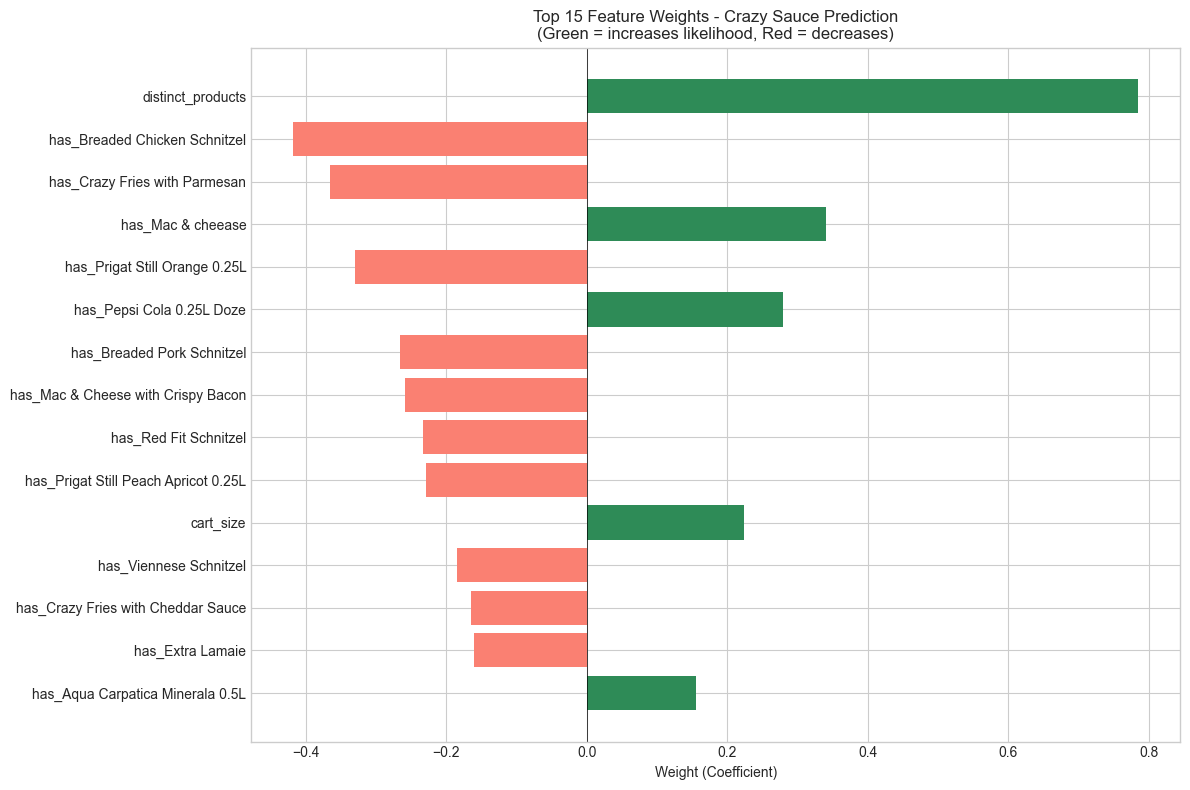

In [14]:
# Feature importance visualization
fig, ax = plt.subplots(figsize=(12, 8))

names = [x[0] for x in top_features]
weights = [x[1]['weight'] for x in top_features]
colors = ['seagreen' if w > 0 else 'salmon' for w in weights]

y_pos = np.arange(len(names))
ax.barh(y_pos, weights, color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.set_xlabel('Weight (Coefficient)')
ax.set_title('Top 15 Feature Weights - Crazy Sauce Prediction\n(Green = increases likelihood, Red = decreases)')
ax.axvline(0, color='black', linewidth=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../results/lr1_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Threshold Analysis

In [15]:
# Try different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    results.append({
        'threshold': thresh,
        'accuracy': accuracy(y_test, y_pred_thresh),
        'precision': precision(y_test, y_pred_thresh),
        'recall': recall(y_test, y_pred_thresh),
        'f1': f1_score(y_test, y_pred_thresh)
    })

results_df = pd.DataFrame(results)

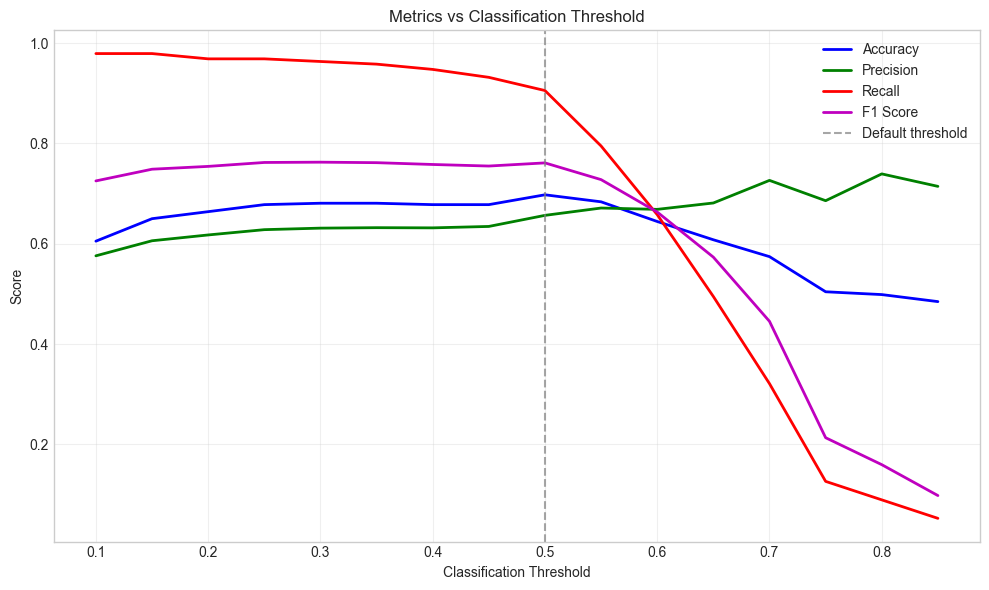


Best F1 Score at threshold 0.30:
  F1: 0.7625
  Accuracy: 0.6807


In [16]:
# Plot metrics vs threshold
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(results_df['threshold'], results_df['accuracy'], 'b-', label='Accuracy', linewidth=2)
ax.plot(results_df['threshold'], results_df['precision'], 'g-', label='Precision', linewidth=2)
ax.plot(results_df['threshold'], results_df['recall'], 'r-', label='Recall', linewidth=2)
ax.plot(results_df['threshold'], results_df['f1'], 'm-', label='F1 Score', linewidth=2)

ax.axvline(0.5, color='gray', linestyle='--', alpha=0.7, label='Default threshold')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Score')
ax.set_title('Metrics vs Classification Threshold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/lr1_threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Best F1 threshold
best_idx = results_df['f1'].idxmax()
print(f"\nBest F1 Score at threshold {results_df.loc[best_idx, 'threshold']:.2f}:")
print(f"  F1: {results_df.loc[best_idx, 'f1']:.4f}")
print(f"  Accuracy: {results_df.loc[best_idx, 'accuracy']:.4f}")

## 7. Summary

In [17]:
print("=" * 60)
print("LOGISTIC REGRESSION #1 SUMMARY")
print("=" * 60)
print(f"\nTask: Predict Crazy Sauce purchase given Crazy Schnitzel order")
print(f"\nDataset:")
print(f"  Total samples: {len(y)}")
print(f"  Features: {X.shape[1]}")
print(f"  Class balance: {100*y.mean():.1f}% positive")
print(f"\nModel Configuration:")
print(f"  Learning rate: {model.learning_rate}")
print(f"  Iterations: {model.n_iterations}")
print(f"  L2 Regularization: {model.regularization}")
print(f"\nTest Set Performance (threshold=0.5):")
print(f"  Accuracy:  {accuracy(y_test, y_pred):.4f}")
print(f"  Precision: {precision(y_test, y_pred):.4f}")
print(f"  Recall:    {recall(y_test, y_pred):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"\nTop 3 Predictive Features:")
for i, (name, data) in enumerate(list(importance.items())[:3]):
    print(f"  {i+1}. {name}: {data['weight']:+.4f}")
print("=" * 60)

LOGISTIC REGRESSION #1 SUMMARY

Task: Predict Crazy Sauce purchase given Crazy Schnitzel order

Dataset:
  Total samples: 1783
  Features: 56
  Class balance: 53.2% positive

Model Configuration:
  Learning rate: 0.1
  Iterations: 1000
  L2 Regularization: 0.01

Test Set Performance (threshold=0.5):
  Accuracy:  0.6975
  Precision: 0.6565
  Recall:    0.9053
  F1 Score:  0.7611

Top 3 Predictive Features:
  1. distinct_products: +0.7846
  2. has_Breaded Chicken Schnitzel: -0.4179
  3. has_Crazy Fries with Parmesan: -0.3659
